In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from spn.structure.Base import Sum, Product, Context, get_nodes_by_type, get_topological_order_layers
from spn.structure.leaves.parametric.Parametric import Gaussian, Categorical
from spn.algorithms.LearningWrappers import learn_mspn
from sklearn.datasets import make_classification
from spn.algorithms.MPE import mpe
from spn.algorithms.EM import EM_optimization
from spn.algorithms.Inference import log_likelihood
from sklearn.model_selection import train_test_split
from utils import random_region_graph, region_graph_to_spn, reassign_node_ids

In [2]:
def map_scopes(spn, inds):
    nodes = get_nodes_by_type(spn)
    scope_mapping = {i: s for i, s in enumerate(inds)}
    for n in nodes:
        sc = list(n.scope)
        new_sc = [scope_mapping[i] for i in sc]
        n.scope = new_sc
    return spn

def reassign_ids(spn):
    nodes = get_nodes_by_type(spn)
    for i, n in enumerate(nodes):
        n.id = i
    return spn

def make_dataset(num_samples, num_features, n_informative, n_redundant, n_classes, n_clusters, n_repeated):
    x, y = make_classification(num_samples, num_features, n_informative=n_informative, 
                               n_redundant=n_redundant, n_classes=n_classes, n_clusters_per_class=n_clusters,
                               n_repeated=n_repeated)
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)
    train_data = np.hstack([train_x, train_y.reshape(-1, 1)])
    test_data = np.hstack([test_x, test_y.reshape(-1, 1)])
    return train_data, test_data

In [8]:
num_features = 20
datasets = {}
for num_corrs in np.arange(0, 18, 2):
    inf = num_features - num_corrs
    train, test = make_dataset(2000, num_features, inf, num_corrs, 2, 1, 0)
    datasets[num_corrs] = (train, test)

In [9]:
num_features = 20

def vertical_fl_indep_assumption(n_clients):
    accs = []
    stds = []
    for r in np.arange(0, 18, 2):
        train_data, test_data = datasets[r]
        train_data = np.copy(train_data)
        test_data = np.copy(test_data)
        y = np.copy(test_data[:, -1])
        test_data[:, -1] = np.nan
        # split data on n clients vertically
        indices = np.arange(train_data.shape[1])
        s = np.array_split(indices, n_clients)
        print(s)
        class_idx = train_data.shape[1] - 1
        exp_accs = []
        for _ in range(10):
            # train one spn on each client
            spns = []
            for cl_idx in s:
                client_data = train_data[:, cl_idx]
                client_features = client_data.shape[1] - 1
                if class_idx in cl_idx:
                    context = Context(parametric_types=[Gaussian]*client_features + [Categorical]).add_domains(client_data)
                else:
                    context = Context(parametric_types=[Gaussian]*(client_features + 1)).add_domains(client_data)
                spn_classification = learn_mspn(client_data, context)
                spn_classification = map_scopes(spn_classification, cl_idx)
                spns.append(spn_classification)
            
            spn = Product(children=spns)
            spn.scope = list(set().union(*[set(n.scope) for n in spns]))
            spn = reassign_ids(spn)
            # evaluate server model
            pred = mpe(spn, test_data)
            pred = pred[:, -1]
            acc = sum(y == pred) / len(y)
            exp_accs.append(acc)
        accs.append(np.mean(exp_accs))
        stds.append(np.std(exp_accs))
    return accs, stds

In [10]:
num_clients = [2, 3, 4, 5]
accs_fl_indep = []
stds_fl_indep = []
for c in num_clients:
    accuracies, stds = vertical_fl_indep_assumption(c)
    accs_fl_indep.append(accuracies)
    stds_fl_indep.append(stds)

/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.

In [11]:
from scipy.special import logsumexp

from spn.algorithms.Gradient import gradient_backward
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.Validity import is_valid

from spn.structure.Base import Sum, get_nodes_by_type, get_number_of_nodes
import numpy as np
from copy import deepcopy

def cond_sum_em_update(allowed_nodes):
    def sum_em_update(node, node_gradients=None, root_lls=None, all_lls=None, **kwargs):
        if node.id in allowed_nodes:
            RinvGrad = node_gradients - root_lls

            for i, c in enumerate(node.children):
                new_w = RinvGrad + (all_lls[:, c.id] + np.log(node.weights[i]))
                node.weights[i] = logsumexp(new_w)

            assert not np.any(np.isnan(node.weights))

            node.weights = np.exp(node.weights - logsumexp(node.weights)) + np.exp(-100)

            node.weights = node.weights / node.weights.sum()

            if node.weights.sum() > 1:
                node.weights[np.argmax(node.weights)] -= node.weights.sum() - 1

            assert not np.any(np.isnan(node.weights))
            assert np.isclose(np.sum(node.weights), 1)
            assert not np.any(node.weights < 0)
            assert node.weights.sum() <= 1, "sum: {}, node weights: {}".format(node.weights.sum(), node.weights)
    return sum_em_update

_node_updates = {Sum: cond_sum_em_update([0])}

def add_node_em_update(node_type, lambda_func):
    _node_updates[node_type] = lambda_func


def EM_optimization_network(spn, data, iterations=5, node_updates=_node_updates, skip_validation=False, **kwargs):
    if not skip_validation:
        valid, err = is_valid(spn)
        assert valid, "invalid spn: " + err

    lls_per_node = np.zeros((data.shape[0], get_number_of_nodes(spn)))

    for _ in range(iterations):
        # one pass bottom up evaluating the likelihoods
        log_likelihood(spn, data, dtype=data.dtype, lls_matrix=lls_per_node)

        gradients = gradient_backward(spn, lls_per_node)

        R = lls_per_node[:, 0]

        for node_type, func in node_updates.items():
            for node in get_nodes_by_type(spn, node_type):
                func(
                    node,
                    node_lls=lls_per_node[:, node.id],
                    node_gradients=gradients[:, node.id],
                    root_lls=R,
                    all_lls=lls_per_node,
                    all_gradients=gradients,
                    data=data,
                    **kwargs
                )

In [12]:
num_features = 20

def vertical_fl(n_clients):
    accs = []
    stds = []
    for r in np.arange(0, 18, 2):
        train_data, test_data = datasets[r]
        train_data = np.copy(train_data)
        test_data = np.copy(test_data)
        y = np.copy(test_data[:, -1])
        test_data[:, -1] = np.nan
        # split data on n clients vertically
        indices = np.arange(train_data.shape[1])
        s = np.array_split(indices, n_clients)
        class_idx = train_data.shape[1] - 1
        exp_accs = []
        for _ in range(3):
            # train one spn on each client
            spns = []
            for cl_idx in s:
                client_data = train_data[:, cl_idx]
                client_features = client_data.shape[1] - 1
                if class_idx in cl_idx:
                    context = Context(parametric_types=[Gaussian]*client_features + [Categorical]).add_domains(client_data)
                else:
                    context = Context(parametric_types=[Gaussian]*(client_features + 1)).add_domains(client_data)
                spn_classification = learn_mspn(client_data, context)
                spn_classification = map_scopes(spn_classification, cl_idx)
                spns.append(spn_classification)
            
            spn = Sum(weights=[1/(n_clients + 1)]*(n_clients + 1))
            scope = list(set().union(*[set(n.scope) for n in spns]))
            spn.scope = scope
            prods = []
            for _ in range(n_clients+1):
                p = Product(children=spns)
                p.scope = scope
                prods.append(p)
            spn.children = prods
            spn = reassign_ids(spn)

            # optimize server SPN
            # NOTE: It's legal to put client data in here since we can propagate likelihoods
            #   over the network without sending private information
            EM_optimization_network(spn, train_data)

            # evaluate server model
            pred = mpe(spn, test_data)
            pred = pred[:, -1]
            acc = sum(y == pred) / len(y)
            exp_accs.append(acc)
        accs.append(np.mean(exp_accs))
        stds.append(np.std(exp_accs))
    return accs, stds

In [13]:
num_clients = [2, 3, 4, 5]
accs_fl_dep = []
stds_fl_dep = []
for c in num_clients:
    accuracies, stds = vertical_fl(c)
    accs_fl_dep.append(accuracies)
    stds_fl_dep.append(stds)

/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jonas/anaconda3/envs/federated-spn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.

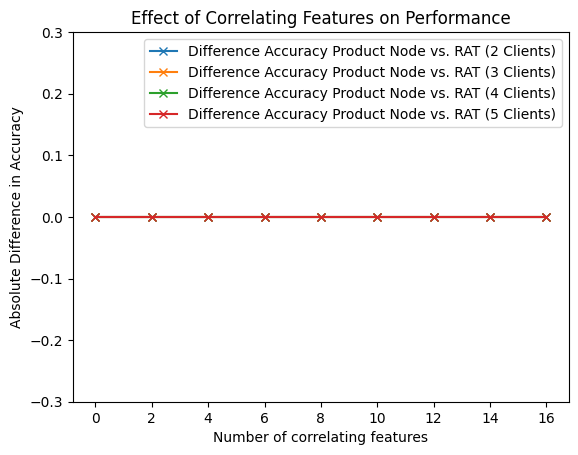

In [15]:
fig = plt.figure()
for ix, c in enumerate(num_clients):
    prod, rat = np.array(accs_fl_indep[ix]), np.array(accs_fl_dep[ix])
    diff = prod - rat
    plt.plot(np.arange(len(rat)), diff, label=f'Difference Accuracy Product Node vs. RAT ({c} Clients)', marker='x')
plt.xticks(np.arange(len(prod)), np.arange(0, len(prod)*2, 2))
plt.xlabel('Number of correlating features')
plt.ylabel('Absolute Difference in Accuracy')
plt.ylim([-0.3, 0.3])
plt.title('Effect of Correlating Features on Performance')
plt.legend()
plt.show()

In [16]:
accs_fl_dep

[[0.8133333333333334,
  0.7916666666666666,
  0.595,
  0.7283333333333334,
  0.705,
  0.855,
  0.84,
  0.8166666666666668,
  0.8216666666666667],
 [0.7983333333333333,
  0.7816666666666666,
  0.6766666666666666,
  0.7133333333333334,
  0.8083333333333332,
  0.835,
  0.8116666666666666,
  0.84,
  0.7933333333333333],
 [0.7183333333333334,
  0.7616666666666667,
  0.6966666666666667,
  0.8066666666666666,
  0.7716666666666666,
  0.9,
  0.785,
  0.86,
  0.7883333333333334],
 [0.67,
  0.745,
  0.6416666666666667,
  0.7166666666666667,
  0.6750000000000002,
  0.8733333333333334,
  0.7600000000000001,
  0.8266666666666667,
  0.805]]

In [17]:
accs_fl_indep

[[0.8133333333333332,
  0.7916666666666667,
  0.595,
  0.7283333333333334,
  0.705,
  0.8550000000000001,
  0.8400000000000001,
  0.8166666666666667,
  0.8216666666666667],
 [0.7983333333333335,
  0.7816666666666665,
  0.6766666666666666,
  0.7133333333333333,
  0.8083333333333333,
  0.835,
  0.8116666666666668,
  0.8400000000000001,
  0.7933333333333332],
 [0.7183333333333335,
  0.7616666666666667,
  0.6966666666666665,
  0.8066666666666666,
  0.7716666666666666,
  0.9,
  0.785,
  0.86,
  0.7883333333333333],
 [0.67,
  0.745,
  0.6416666666666667,
  0.7166666666666667,
  0.675,
  0.8733333333333333,
  0.76,
  0.8266666666666665,
  0.805]]